# Machine Translation Project: English to French (Europarl v8)

## Project Overview
In this project, we aim to build and evaluate machine translation models to translate text from **English to French**. We utilize the **Europarl v8** dataset, which consists of parallel texts extracted from the proceedings of the European Parliament.

The goal of this notebook is to cover the entire pipeline of an NLP project, including:
* **Data Analysis:** Understanding the dataset, split sizes, and token distributions.
* **Baselines:** Establishing simple baselines (e.g., Majority Class or Simple Dictionary) to benchmark performance.
* **Modeling:** Developing neural models, specifically focusing on architectures that utilize **embeddings** (e.g., Seq2Seq with LSTM/GRU or Transformers).
* **Evaluation:** Using standard metrics (such as BLEU scores) to assess model performance.
* **Error Analysis:** Discussing the limitations and specific failure cases of our models.


## Team Contribution
For every parts, we've discussed together on a concrete and precise plan on what to do. The following is about the code & report : 
* **Maxime HAYAKAWA IVANOVIC:** `1. Data loading & visualization` & `2. Data cleaning and filtering` & corresponding parts in the report. 
* **[Member Name 2]:** [Specific contribution, e.g., Neural model architecture, Training loop]
* **[Member Name 3]:** [Specific contribution, e.g., Evaluation metrics, Error analysis]

# 1. Data loading & visualization

First, we set up the environment by defining the file paths for the dataset. We use `pathlib` to ensure the paths work across different operating systems and verify that both the English (Source) and French (Target) files are accessible.

In [4]:
from pathlib import Path
from collections import defaultdict
import re

# 1. Setup Paths
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"

# Define the specific files you have
EN_PATH = DATA_DIR / "Europarl.en-fr.en"
FR_PATH = DATA_DIR / "Europarl.en-fr.fr"

# Verify they exist
if EN_PATH.exists() and FR_PATH.exists():
    print(f"Found English file: {EN_PATH.name}")
    print(f"Found French file:  {FR_PATH.name}")
else:
    print("Error: Files not found. Check your folder structure.")

Found English file: Europarl.en-fr.en
Found French file:  Europarl.en-fr.fr


### Loading Data 

We adapt our loading function to return a **Pandas DataFrame**, which offers advantages such as handling large tables more efficiently than standard Python lists.

The function reads the files line-by-line to ensure safety and alignment, filters out empty lines, and then converts the result into a structured DataFrame.

In [5]:
import pandas as pd

def load_parallel_subset(en_path, fr_path, max_lines):
    """
    Reads two aligned text files and returns a Pandas DataFrame with columns ['en', 'fr'].
    """
    pairs = []
    
    try:
        # Open both files at the same time
        with open(en_path, "r", encoding="utf-8") as f_en, \
             open(fr_path, "r", encoding="utf-8") as f_fr:
            
            # zip() pairs lines together safely
            for i, (line_en, line_fr) in enumerate(zip(f_en, f_fr)):
                if i >= max_lines:
                    break
                
                text_en = line_en.strip()
                text_fr = line_fr.strip()
                
                # Only keep if both sides have content
                if text_en and text_fr:
                    pairs.append((text_en, text_fr))
                    
    except Exception as e:
        print(f"Error reading files: {e}")
        return pd.DataFrame()  # Return empty DF on error

    # Convert list of tuples to DataFrame
    df = pd.DataFrame(pairs, columns=["en", "fr"])
    return df

In [6]:
subset_size = 500000

In [7]:
# Run the loader
df = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size)
print(f"Successfully loaded {len(df)} pairs.")

Successfully loaded 500000 pairs.


### Quick look on some samples (`k` random ones)

In [8]:
import pandas as pd

def sample_pairs(df, k):
    """Print k random sample pairs from a DataFrame."""
    if df.empty:
        print("DataFrame is empty.")
        return

    # Use min() to ensure we don't sample more rows than exist
    sample_df = df.sample(n=min(k, len(df)))

    print("\n=== Sample pairs ===")
    
    # Iterate over the sampled rows
    for i, row in enumerate(sample_df.itertuples(), 1):
        en_text = row.en
        fr_text = row.fr
        
        print(f"--- Pair {i} ---")
        print(f"EN: {en_text[:200]}{'...' if len(en_text) > 200 else ''}")
        print(f"FR: {fr_text[:200]}{'...' if len(fr_text) > 200 else ''}")
        print()

In [9]:
nb_samples = 7

In [10]:
sample_pairs(df, nb_samples)


=== Sample pairs ===
--- Pair 1 ---
EN: There is one point that I want to emphasise very strongly.
FR: Il est un point que je voudrais souligner tout particulièrement.

--- Pair 2 ---
EN: If we do not achieve this, then this is a declaration of environmental bankruptcy.
FR: Si nous n' y parvenons pas, il s' agit d' une déclaration de faillite en matière d' environnement.

--- Pair 3 ---
EN: We Swedish Social Democrats chose to vote against quite a number of the amendments in the report concerning monitoring of forests and environmental interactions in the Community (Forest Focus).
FR: Les sociaux-démocrates suédois ont choisi de voter contre plusieurs amendements du rapport concernant la surveillance des forêts et des interactions environnementales dans la Communauté (Forest Focus)...

--- Pair 4 ---
EN: Thank you so much, Commissioner, for your important statement.
FR: Merci infiniment, Madame la Commissaire, pour votre déclaration importante.

--- Pair 5 ---
EN: .
FR: J'ai voté en f

### Exploratory Data Analysis: Basic Statistics

We compute basic statistics to understand the length distribution of our parallel sentences. 

**Important Decisions:**
* **Stopwords:** We **do not** remove stopwords. In Machine Translation, function words (like "le", "de", "the", "to") are critical for constructing grammatically correct sentences in the target language.
* **Tokenization:** For this initial analysis, we use simple whitespace splitting to approximate word counts.  
* **Efficiency:** We utilize Pandas vectorization to compute lengths across the entire dataset instantly.

In [11]:
import numpy as np

def basic_stats(df):
    """
    Computes and prints basic statistics using Pandas for efficiency.
    """
    if df.empty:
        print("No data loaded.")
        return {}

    # 1. Compute lengths (Vectorized)
    # Character counts
    df['en_char_len'] = df['en'].str.len()
    df['fr_char_len'] = df['fr'].str.len()
    
    # Word counts (approximate using split)
    df['en_word_len'] = df['en'].str.split().str.len()
    df['fr_word_len'] = df['fr'].str.split().str.len()

    # 2. Compute aggregations
    stats = {
        "n_pairs": len(df),
        "en_char_mean": df['en_char_len'].mean(),
        "fr_char_mean": df['fr_char_len'].mean(),
        "en_word_mean": df['en_word_len'].mean(),
        "fr_word_mean": df['fr_word_len'].mean(),
        "en_char_min": df['en_char_len'].min(),
        "en_char_max": df['en_char_len'].max(),
        "fr_char_min": df['fr_char_len'].min(),
        "fr_char_max": df['fr_char_len'].max(),
    }

    # 3. Print Results
    print("=== Basic Statistics ===")
    print(f"Number of sentence pairs: {stats['n_pairs']:,}")
    print(f"English — chars: mean={stats['en_char_mean']:.1f}, min={stats['en_char_min']}, max={stats['en_char_max']}")
    print(f"French  — chars: mean={stats['fr_char_mean']:.1f}, min={stats['fr_char_min']}, max={stats['fr_char_max']}")
    print(f"English — words/sentence: mean={stats['en_word_mean']:.1f}")
    print(f"French  — words/sentence: mean={stats['fr_word_mean']:.1f}")
    
    return stats

In [12]:
print(basic_stats(df))

=== Basic Statistics ===
Number of sentence pairs: 500,000
English — chars: mean=151.5, min=1, max=1871
French  — chars: mean=167.2, min=1, max=1459
English — words/sentence: mean=25.5
French  — words/sentence: mean=26.6
{'n_pairs': 500000, 'en_char_mean': np.float64(151.468862), 'fr_char_mean': np.float64(167.221542), 'en_word_mean': np.float64(25.516568), 'fr_word_mean': np.float64(26.591636), 'en_char_min': np.int64(1), 'en_char_max': np.int64(1871), 'fr_char_min': np.int64(1), 'fr_char_max': np.int64(1459)}


Based on 500,000 sentence pairs, we observe the following characteristics:

* **Text Expansion:** French sentences are consistently longer than their English counterparts. On average, French segments have **~167 characters** compared to **~151 for English** (roughly **10% longer** in characters). This aligns with the linguistic expectation that French is generally more verbose than English.
* **Sequence Length:** The average sentence length is around **25-27 words**. 
* **Outliers:**
    * **Max Length:** The maximum English sentence length is **1,871 characters** (and 1,459 for French). These extremely long sequences are likely parsing errors or lists within the parliamentary proceedings. They will need to be filtered out to avoid memory issues during training.
    * **Min Length:** The minimum length of **1** suggests noise (e.g., isolated punctuation or numbering). These should also be removed.

**Conclusion:** We should implement a filtering step to remove sentences that are too long (e.g., > 100 words) or too short, ensuring our model trains on high-quality sentence pairs.

### Visualizing Sentence Length Distribution

We visualize the distribution of sentence lengths (in number of words) using **histograms**.

**What this tells us:**
* **Distribution Shape:** We can observe if the sentence lengths follow a typical log-normal distribution.
* **Language Comparison:** By overlaying English and French, we can clearly see the "shift" where French sentences (red) tend to be longer than English sentences (blue).
* **Tail:** The right side of the graph reveals the "long tail" of unusually long sentences that we may need to filter out.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sentence_length_distribution(df, bins=50):
    """
    Plots the distribution of sentence lengths (word count) using only Histograms.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Ensure word counts are computed
    if 'en_word_len' not in df.columns:
        df['en_word_len'] = df['en'].str.split().str.len()
        df['fr_word_len'] = df['fr'].str.split().str.len()

    plt.figure(figsize=(10, 6))

    # Overlaid Histogram
    sns.histplot(df['en_word_len'], bins=bins, color='blue', alpha=0.4, label='English', kde=True, linewidth=0.4)
    sns.histplot(df['fr_word_len'], bins=bins, color='red', alpha=0.4, label='French', kde=True, linewidth=0.4)
    
    plt.title("Distribution of Sentence Lengths (Word Count)")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
bins = 50

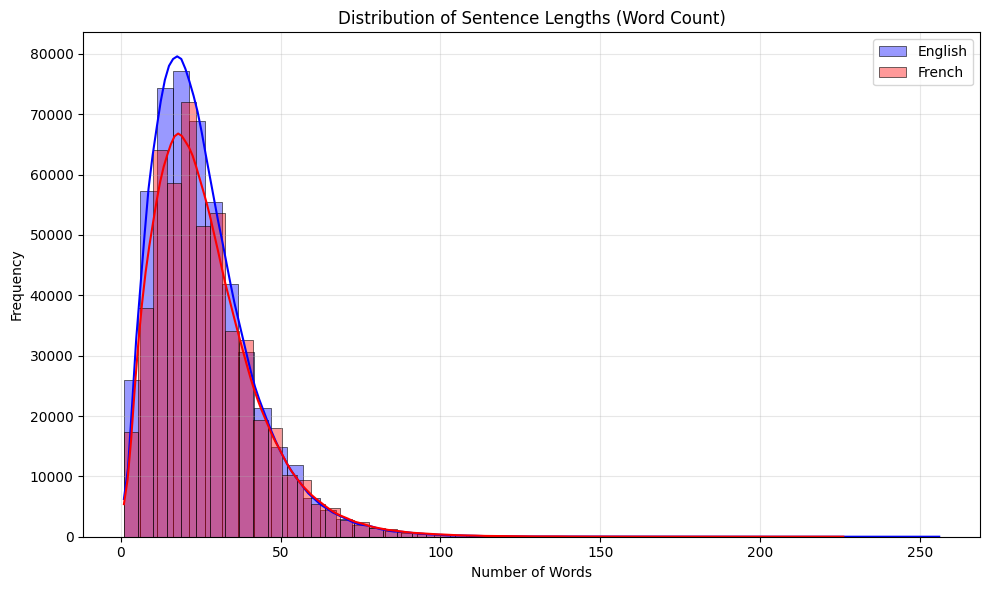

In [15]:
plot_sentence_length_distribution(df, bins)

### Word Clouds

To get a simple viewof  the corpus content, we generate **Word Clouds**. These visualizations scale the size of each word by its frequency in the dataset.

**What we expect to see:**
* **Political Terminology:** Since this is the Europarl corpus, words like "President", "European", "Commission", "Council", "Union" should be very prominent.
* **Cognates:** We should see similar-looking prominent words in both clouds (e.g., "Parliament" vs. "Parlement"), visually confirming the alignment of the dataset.

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def plot_word_clouds(df, sample_size=50000):
    """
    Generates and plots Word Clouds for English and French text.
    Uses .to_image() to fix numpy compatibility issues.
    """
    if df.empty:
        print("No data to plot.")
        return

    # 1. Prepare Text
    if len(df) > sample_size:
        print(f"Sampling {sample_size} sentences for WordCloud generation...")
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df

    # Join text into massive strings (required by WordCloud)
    text_en = " ".join(df_sample['en'].dropna().astype(str))
    text_fr = " ".join(df_sample['fr'].dropna().astype(str))

    # 2. Setup WordCloud Objects
    # English: Blue background or blue color map
    wc_en = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='Blues',
        max_words=100,
        stopwords=set(STOPWORDS)
    ).generate(text_en)

    # French: Red color map (We need to add French stopwords manually or use a library)
    fr_stopwords = set(STOPWORDS).union({
        "le", "la", "les", "de", "des", "du", "un", "une", "et", "est", "en", 
        "que", "qui", "dans", "pour", "sur", "par", "plus", "pas", "ce", "cette", "au"
    })
    
    wc_fr = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='Reds',
        max_words=100,
        stopwords=fr_stopwords
    ).generate(text_fr)

    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # FIX IS HERE: We utilize .to_image() to pass a PIL Image directly
    ax1.imshow(wc_en.to_image(), interpolation='bilinear')
    ax1.set_title("English Word Cloud", fontsize=16, color='navy')
    ax1.axis('off')

    # FIX IS HERE: .to_image()
    ax2.imshow(wc_fr.to_image(), interpolation='bilinear')
    ax2.set_title("French Word Cloud", fontsize=16, color='darkred')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

Sampling 50000 sentences for WordCloud generation...


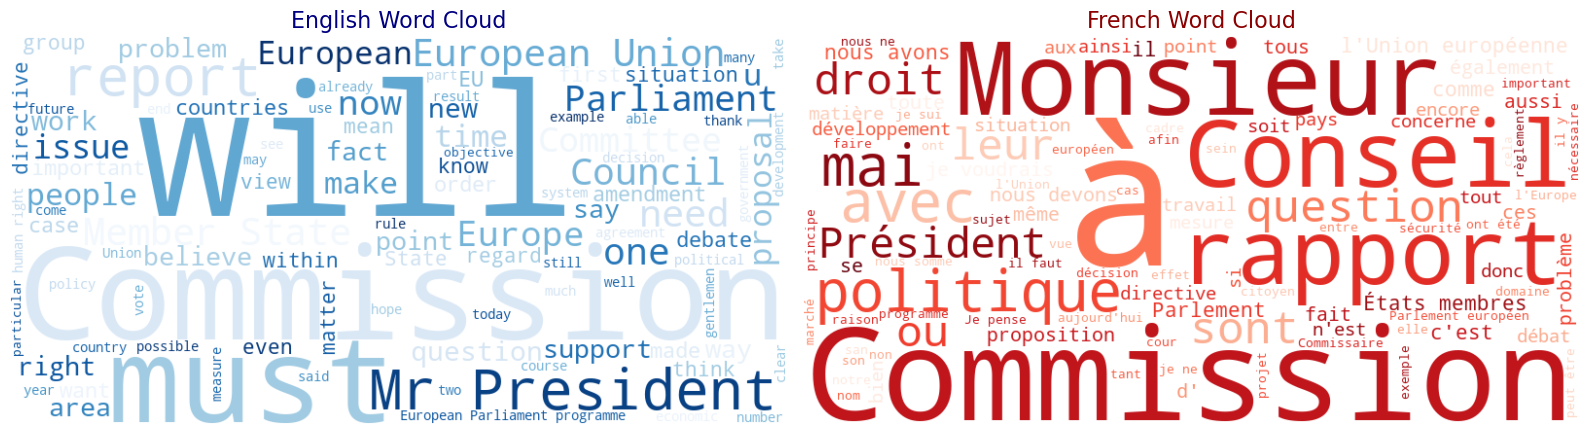

In [74]:
plot_word_clouds(df)

### Visualizing Sentence Length Correlation

We use a scatter plot to visualize the relationship between English and French sentence lengths.

**What to look for:**
* **Linear Correlation:** We expect a strong linear trend where longer English sentences correspond to longer French sentences.
* **The "French Expansion":** Most points should lie slightly above the diagonal ($y=x$), reflecting that French text is generally longer.
* **Outliers:** Points far from the main cluster (e.g., very long English but short French, or vice versa) often indicate alignment errors or garbage data that should be filtered out.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_length_scatter(df, sample_size):
    """
    Generates a scatter plot comparing English vs. French sentence lengths.
    Uses a random sample for performance if the dataset is large.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Ensure lengths are computed
    if 'en_char_len' not in df.columns:
        df['en_char_len'] = df['en'].str.len()
        df['fr_char_len'] = df['fr'].str.len()

    # Sample the data to avoid over-plotting and slow performance
    if len(df) > sample_size:
        plot_df = df.sample(n=sample_size, random_state=42)
        title_suffix = f"(Sample of {sample_size})"
    else:
        plot_df = df
        title_suffix = "(All Data)"

    # --- Setup Plot ---
    plt.figure(figsize=(8, 8))
    
    # Scatter plot
    sns.scatterplot(
        x='en_char_len', 
        y='fr_char_len', 
        data=plot_df, 
        alpha=0.4, 
        color='purple',
        edgecolor=None  # Remove edge color for smoother look with many points
    )
    
    # Add a reference line y=x (no expansion)
    max_val = max(plot_df['en_char_len'].max(), plot_df['fr_char_len'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.6, linewidth=2, label='y=x (1:1 ratio)')
    
    plt.title(f"Sentence Length Correlation: English vs. French {title_suffix}")
    plt.xlabel("English Character Count")
    plt.ylabel("French Character Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("length_correlation.png") # Save just in case you want to use it in the report
    plt.show()

In [18]:
sample_size = 5000

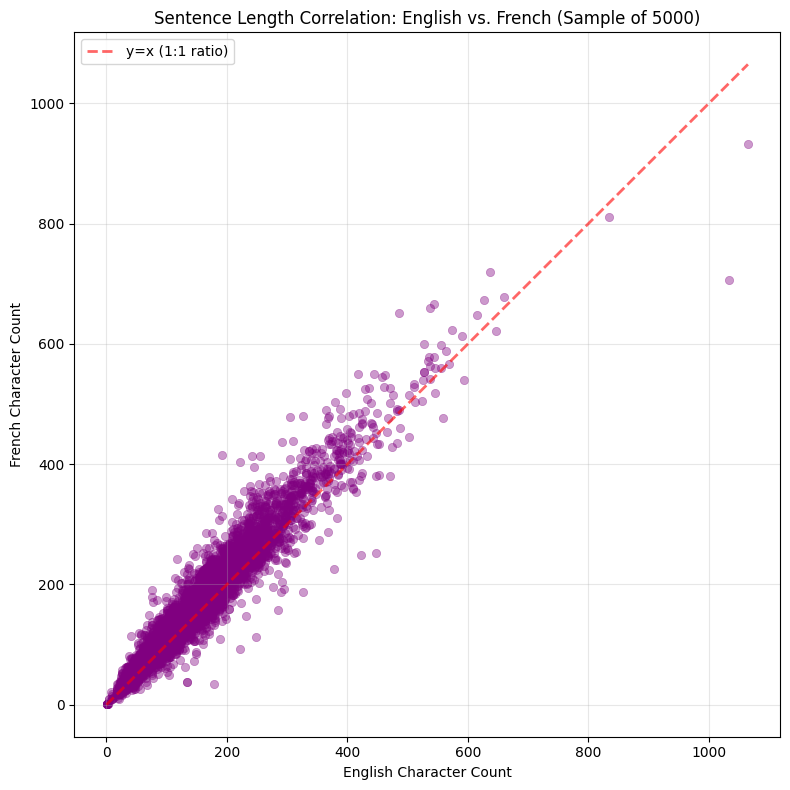

In [19]:
plot_length_scatter(df, sample_size)

### Visualizing Vocabulary Trends: Top Frequent Words

We analyze the most frequent words in both languages to understand the dataset's vocabulary distribution.

**Expected Trends:**
* **Stopwords:** We expect the top ranking words to be functional stopwords (e.g., "the", "of", "le", "de").
* **Domain Specificity:** Since this is Europarl, we might see domain-specific words like "european", "parliament", or "president" appearing relatively high in the list.
* **Noise:** If we see punctuation or weird symbols in the top list, it indicates a need for better cleaning.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import pandas as pd

def plot_top_words(df, top_n):
    """
    Plots the top N most frequent words for English and French using Bar Charts.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Helper function to get top words
    def get_top_counts(text_series):
        # Join all text (efficient for medium datasets) or iterate
        # Using a regex to split matches the logic of your original code
        word_re = re.compile(r"\b\w+\b", re.UNICODE)
        
        # We use a Counter to aggregate counts efficiently
        # Flattening the list of words for all rows
        all_words = (
            word
            for text in text_series
            for word in word_re.findall(text.lower())
        )
        return Counter(all_words).most_common(top_n)

    # 1. Compute Counts
    en_top = get_top_counts(df['en'])
    fr_top = get_top_counts(df['fr'])
    
    # Convert to DataFrames for easy plotting with Seaborn
    df_en_top = pd.DataFrame(en_top, columns=['Word', 'Count'])
    df_fr_top = pd.DataFrame(fr_top, columns=['Word', 'Count'])

    # 2. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # English Plot
    sns.barplot(x='Count', y='Word', data=df_en_top, ax=ax1, palette='Blues_r')
    ax1.set_title(f"Top {top_n} Words (English)")
    ax1.set_xlabel("Frequency")
    
    # French Plot
    sns.barplot(x='Count', y='Word', data=df_fr_top, ax=ax2, palette='Reds_r')
    ax2.set_title(f"Top {top_n} Words (French)")
    ax2.set_xlabel("Frequency")
    
    plt.tight_layout()
    plt.show()

In [21]:
N_top_words = 15

/var/folders/1x/bcx97cwn2l38q006s07v1kr00000gn/T/ipykernel_21787/3391826528.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_en_top, ax=ax1, palette='Blues_r')
/var/folders/1x/bcx97cwn2l38q006s07v1kr00000gn/T/ipykernel_21787/3391826528.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_fr_top, ax=ax2, palette='Reds_r')


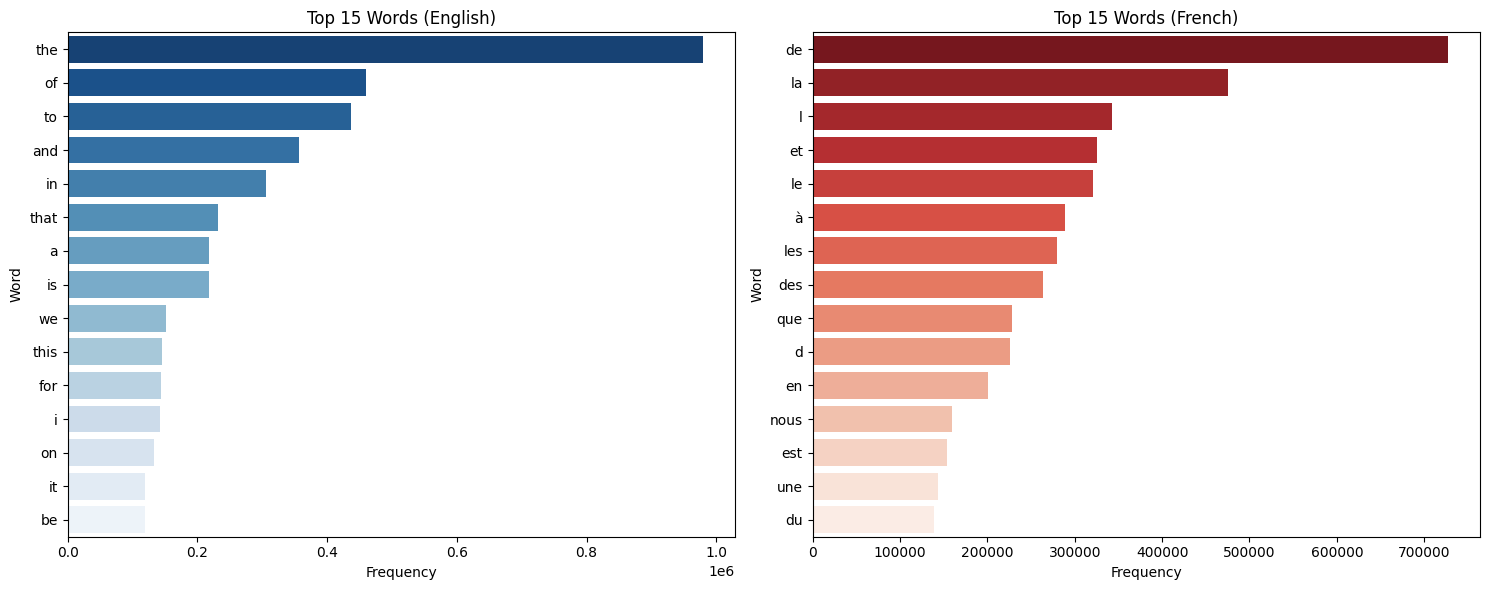

In [22]:
plot_top_words(df, top_n=N_top_words)

### Visualizing Vocabulary Distribution (Zipf's Law)

We verify if our dataset follows **Zipf's Law**, which states that the frequency of any word is inversely proportional to its rank in the frequency table.

**Why checking this is important:**
* **Natural Language Verification:** A straight line on a log-log plot confirms the dataset has the statistical properties of natural human language.
* **Quality Check:** Deviations (e.g., a "staircase" pattern or a flat line) would indicate synthetic data, excessive duplication, or preprocessing errors.

In [23]:
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np

def plot_zipf_law(df):
    """
    Plots the word frequency distribution on a log-log scale to check Zipf's Law.
    Adapted for Pandas DataFrame input.
    """
    if df.empty:
        print("No data to plot.")
        return
    
    # 1. Tokenize and Count (Lightweight for EDA)
    # Using regex to find words, ignoring punctuation
    word_re = re.compile(r"\b\w+\b", re.UNICODE)
    
    def get_freqs(series):
        # Generator expression is memory efficient
        all_words = (word for text in series for word in word_re.findall(text.lower()))
        counts = Counter(all_words)
        # Return frequencies sorted by rank (descending)
        return sorted(counts.values(), reverse=True)

    print("Computing word frequencies... (this may take a moment)")
    en_freqs = get_freqs(df['en'])
    fr_freqs = get_freqs(df['fr'])
    
    # 2. Plotting
    plt.figure(figsize=(10, 6))
    
    # Log-Log Plot
    plt.loglog(en_freqs, label='English', color='blue', linewidth=2, alpha=0.8)
    plt.loglog(fr_freqs, label='French', color='red', linestyle='--', linewidth=2, alpha=0.8)
    
    plt.title("Zipf's Law Check (Log-Log Plot)")
    plt.xlabel("Rank (Log Scale)")
    plt.ylabel("Frequency (Log Scale)")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.4)
    
    plt.tight_layout()
    plt.show()

Computing word frequencies... (this may take a moment)


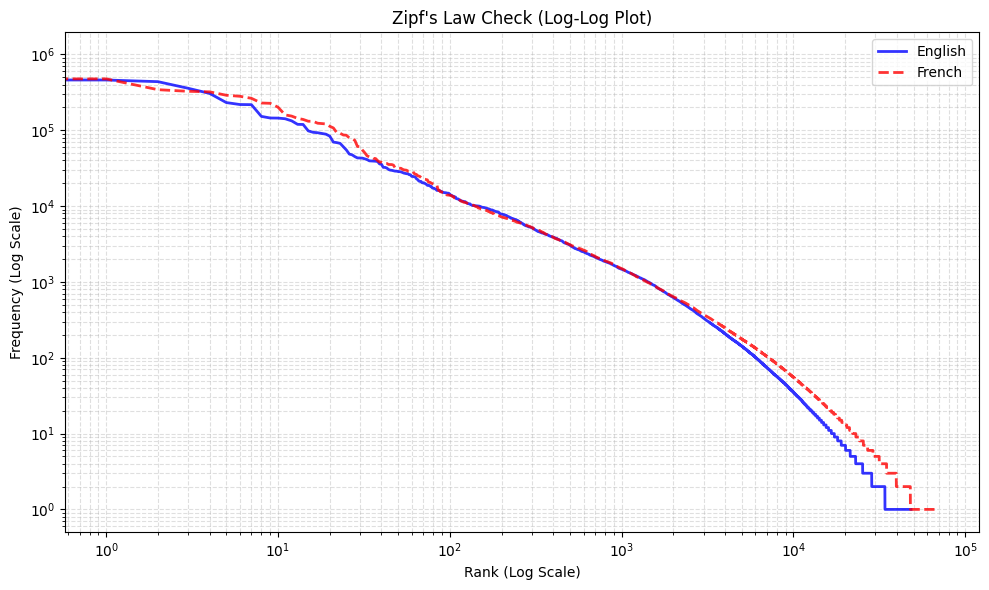

In [24]:
plot_zipf_law(df)

The log–log plot displays a clear, nearly linear trend between rank and frequency, confirming that the word frequency distributions for both English and French are consistent with **Zipf’s law**.

Key observations:
* **Power Law Distribution:** The straight diagonal line indicates that a very small number of unique words occur extremely often (likely function words like "the", "to", "le", "de"), while the vast majority of words appear very rarely (the "long tail").
* **Language Comparison:** Both English and French follow almost identical distributions. The French curve (red dashed line) sits slightly higher and extends further in the lower-frequency region (the tail). This is consistent with French having a richer morphology (more distinct word forms due to conjugations and gender agreements) than English, resulting in a slightly larger vocabulary of unique tokens.
* **Dataset Quality:** The smoothness of the curves suggests the dataset is comprised of natural language without significant artificial noise or duplication artifacts.

# 2. Data pre-processing

### Cleaning

Based on our analysis, we apply filtering to remove noise and outliers. This ensures our model trains on coherent, aligned data.

In [25]:
import pandas as pd
import numpy as np

def filter_dataset(df, min_words=3, max_words=100, max_ratio=2.0):
    """
    Filters the dataset based on word length and length ratio.
    """
    if df.empty:
        print("Dataset is empty!")
        return df

    original_count = len(df)

    # Ensure word counts exist (using split as a proxy)
    if 'en_word_len' not in df.columns:
        df['en_word_len'] = df['en'].str.split().str.len()
        df['fr_word_len'] = df['fr'].str.split().str.len

    # 1. Length Filtering (Min/Max words)
    mask_len = (
        (df['en_word_len'] >= min_words) & (df['en_word_len'] <= max_words) &
        (df['fr_word_len'] >= min_words) & (df['fr_word_len'] <= max_words)
    )
    
    # Ratio logic: larger / smaller should be < max_ratio
    # This handles both cases (fr >> en and en >> fr)
    len_a = df['en_word_len'].replace(0, 1)
    len_b = df['fr_word_len'].replace(0, 1)
    
    ratio_1 = len_a / len_b
    ratio_2 = len_b / len_a
    mask_ratio = (ratio_1 < max_ratio) & (ratio_2 < max_ratio)

    # Apply Filters
    df_clean = df[mask_len & mask_ratio].copy()
    
    df_clean.reset_index(drop=True, inplace=True)
    
    removed_count = original_count - len(df_clean)
    
    print(f"=== Filtering Results ===")
    print(f"Original size:  {original_count:,}")
    print(f"Removed:        {removed_count:,} ({removed_count/original_count:.2%})")
    print(f"Remaining:      {len(df_clean):,}")
    
    return df_clean

**Filtering Criteria:**
1.  **Min Length:** We remove extremely short sentences (e.g., < 3 words) which are often just numbering, punctuation, or isolated words without context.
2.  **Max Length:** We remove extremely long sentences (e.g., > 100 words). These are computationally expensive to train on (causing OOM errors) and often represent lists or parsing errors.
3.  **Length Ratio:** We remove pairs where the length ratio is extreme (e.g., one sentence is 3x longer than the other), as these likely indicate poor alignment or missing translations.

In [26]:
min_length = 3
max_length = 100
length_ratio = 2.5

In [27]:
df_clean = filter_dataset(df, min_length, max_length, length_ratio)

=== Filtering Results ===
Original size:  500,000
Removed:        6,061 (1.21%)
Remaining:      493,939


### Preprocessing pipeline

To streamline our workflow, we wrap the normalization and tokenization steps into a single function.

**The pipeline:**
1.  **Normalization:** We apply `NFKC` normalization and lowercasing to standardizes the text.
2.  **Tokenizer Training:** We train a BPE tokenizer on the normalized corpus to create our vocabulary.
3.  **Encoding:** We demonstrate how the tokenizer converts text into ID sequences.

In [28]:
import pandas as pd
import unicodedata
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

def run_preprocessing_pipeline(df, vocab_size):
    """
    1. Normalizes the dataframe (text -> text).
    2. Trains a BPE tokenizer on the normalized data.
    3. Returns the normalized dataframe and the trained tokenizer.
    """
    print("--- Starting Preprocessing Pipeline ---")

    def normalize(text):
        if not isinstance(text, str): return ""
        return unicodedata.normalize('NFKC', text).lower()

    print(f"Normalizing {len(df):,} pairs...")
    # We work on a copy to avoid SettingWithCopy warnings
    df_clean = df.copy()
    df_clean['en'] = df_clean['en'].apply(normalize)
    df_clean['fr'] = df_clean['fr'].apply(normalize)
    
    print("Training BPE Tokenizer...")
    
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(
        vocab_size=vocab_size, 
        special_tokens=["[PAD]", "[UNK]", "[SOS]", "[EOS]"]
    )
    
    # Prepare iterator (En + Fr combined for shared vocab)
    corpus = (
        df_clean['en'].dropna().astype(str).tolist() + 
        df_clean['fr'].dropna().astype(str).tolist()
    )
    
    tokenizer.train_from_iterator(corpus, trainer=trainer)
    tokenizer.save("europarl_bpe.json")
    print(f"   Tokenizer trained! Vocab size: {tokenizer.get_vocab_size()}")

    # --- Step 3: Verify ---
    sample_text = df_clean.iloc[0]['en']
    encoded = tokenizer.encode(sample_text)
    print(f"\nSample Input: '{sample_text}'")
    print(f"Token IDs:    {encoded.ids}")
    
    return df_clean, tokenizer

In [29]:
vocab_size = 20000

In [30]:
df_normalized, tokenizer = run_preprocessing_pipeline(df_clean, vocab_size)

--- Starting Preprocessing Pipeline ---
Normalizing 493,939 pairs...
Training BPE Tokenizer...



   Tokenizer trained! Vocab size: 20000

Sample Input: 'resumption of the session'
Token IDs:    [16244, 143, 122, 2763]


In [31]:
# Normalized sentences
sample_pairs(df_normalized, 3)


=== Sample pairs ===
--- Pair 1 ---
EN: much has been said about solidarity and security.
FR: on parle beaucoup de solidarité et de sécurité.

--- Pair 2 ---
EN: mr president, in the last few decades southern africa has formed the subject of much attention in this house.
FR: monsieur le président, l'afrique australe a fait l'objet d'une attention soutenue au sein de ce parlement pendant la décennie écoulée, avec raison d'ailleurs.

--- Pair 3 ---
EN: that all expenditure by the state should be tested applies, though, not only in my own country, but is true of all subsidies.
FR: toutefois, mon pays n' est pas le seul dont les dépenses publiques ou toutes les subventions doivent être contrôlées.



In [32]:
sample_text = df_clean.iloc[0]['en']
encoded = tokenizer.encode(sample_text)
print(f"Sample input: '{sample_text}'")
print(f"Token IDs: {encoded.ids}")

Sample input: 'Resumption of the session'
Token IDs: [1, 111, 57, 5411, 143, 122, 2763]
